In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import animation, rc, image
import seaborn as sns
import math
from math import sin, cos
# Importing library 
import csv 
# using datetime module 
import datetime;

In [ ]:
#Fixed parameters
in_size = 5     #Number of observations (pos_x, pos_y, theta, goal_x, goal_y)
out_size = 2    #Number of o

#Policy parameters
hidden_size = 5        # How many values in the hidden layer
hidden2_size = 5


#Training parameters
cem_iterations = 200    # How many total CEM iterations 
cem_batch_size = 800     # How many guassian samples in each CEM iteration
cem_elite_frac = 0.3    # What percentage of cem samples are used to fit the guassian for next iteration
cem_init_stddev = 1.0   # Initial CEM guassian uncertainty
cem_noise_factor = 0.3    # Scaling factor of how much extra noise to add each iteration (noise_factor/iteration_number noise is added to std.dev.)
cem_print_rate = 5

#Simulation paramters
dt = 0.1    #seconds
runtime = 8 #seconds

#Target task
car_start = np.array((-50,0,0.751))
car_goal = np.array((50,0))
#s_arr = np.array([[-50,0,0.751],[-150,-100,0],[150,100,0],[-20,0,0],[100,0,0],[-150,100,0.751]])
#g_arr = np.array([[50,0],[150,100],[-150,-100],[0,0],[-100,0],[150,-50]])
#s_arr = np.array([[-100,0,0.751],[-100,0,0.751],[-100,0,0.751],[-100,0,0.751],[-100,0,0.751]])
#g_arr = np.array([[50,0],[150,100],[50,50],[50,-50],[100,0]])
#s_arr = np.array([[-100,0,0.751],[-100,0,0.751],[-100,0,0.751]])
#g_arr = np.array([[100,0],[100,50],[100,-50]])
#s_arr = np.array([[-100,50,0],[-90,60,0],[-110,50,0]])
#g_arr = np.array([[100,-50],[100,-50],[100,-50]])
s_arr = np.array([[-100,100,0],[-100,150,0],[-150,100,0],[-150,150,0],[-100,100,0],[-100,150,0],[-150,100,0],[-150,150,0]])
g_arr = np.array([[100,-50],[100,-50],[100,-50],[100,-50],[150,-100],[150,-100],[150,-100],[150,-100]])

evalation_samples = len(s_arr) # How many samples to take when evaluating a network

#Car dynamics paramters
v_max = 80  #units/sec
omega_max = 3.14 #pi radians/sec = 180 deg/sec turn speed

#Car shape
car_w = 5
car_l = 10

saved_params = []

In [ ]:
two_layer_policy_size = (in_size+1)*hidden_size + (hidden_size+1)*out_size
def two_layer_model(params, in_data):
  in_vec = np.array(in_data).reshape(in_size,1) #place input data in a column vector

  #Layer 1 (input -> hidden)
  m1_end = hidden_size*in_size
  matrix1 = np.reshape(params[0:m1_end], (hidden_size,in_size))
  biases1 = np.reshape(params[m1_end:m1_end+hidden_size], (hidden_size,1))
  hidden_out = (matrix1 @ in_vec) + biases1
  hidden_out = hidden_out * (hidden_out > 0) + 0.1*hidden_out * (hidden_out < 0) #Leaky ReLU  

  #Layer 2 (hiden -> output)
  m2_start = m1_end+hidden_size
  m2_end = m2_start + out_size*hidden_size
  matrix2 = np.reshape(params[m2_start:m2_end], (out_size,hidden_size))
  biases2 = np.reshape(params[m2_end:m2_end+out_size], (out_size,1))
  result = (matrix2 @ hidden_out) + biases2
  return result.reshape(out_size,)

cur_Model = two_layer_model
policy_size = two_layer_policy_size

In [ ]:
three_layer_policy_size = (in_size+1)*hidden_size + (hidden_size+1)*hidden_size + (hidden_size+1)*out_size
def three_layer_model(params, in_data):
  in_vec = np.array(in_data).reshape(in_size,1) #place input data in a column vector

  #Layer 1 (input -> hidden1)
  m1_end = hidden_size*in_size
  matrix1 = np.reshape(params[0:m1_end], (hidden_size,in_size))
  biases1 = np.reshape(params[m1_end:m1_end+hidden_size], (hidden_size,1))
  hidden1_out = (matrix1 @ in_vec) + biases1
  hidden1_out = hidden1_out * (hidden1_out > 0) + 0.1*hidden1_out * (hidden1_out < 0) #Leaky ReLU

  #Layer 2 (hidden1 -> hidden2)
  m2_start = m1_end+hidden_size
  m2_end = m2_start + hidden2_size*hidden_size
  matrix2 = np.reshape(params[m2_start:m2_end], (hidden2_size,hidden_size))
  biases2 = np.reshape(params[m2_end:m2_end+hidden2_size], (hidden2_size,1))
  hidden2_out = (matrix2 @ hidden1_out) + biases2
  hidden2_out = hidden2_out * (hidden2_out > 0) + 0.1*hidden2_out * (hidden2_out < 0) #Leaky ReLU

  #Layer 3 (hidden2 -> output)
  m3_start = m2_end+hidden2_size
  m3_end = m3_start + out_size*hidden2_size
  matrix3 = np.reshape(params[m3_start:m3_end], (out_size,hidden2_size))
  biases3 = np.reshape(params[m3_end:m3_end+out_size], (out_size,1))
  result = (matrix3 @ hidden2_out) + biases3
  return result.reshape(out_size,)

cur_Model = three_layer_model
policy_size = three_layer_policy_size

In [ ]:
#The the input paramters theta that maximize the function f
#CEM will extimate a guassian of the optimal theta represented as
#  th_mean (the means) and th_std (the standard deviation).
#This CEM implementation, has one value of std.dev. for each paramter, and
#  ignores off-diagnol terms of the co-variance matrix
def cem(f, th_mean, batch_size, n_iter, elite_frac, initial_std=1.0):
  n_elite = int(np.round(batch_size*elite_frac))
  th_std = np.ones_like(th_mean) * initial_std

  for iter in range(n_iter):
    #Add noise to batch_size samples 
    ths = np.array([th_mean + dth for dth in  th_std[None,:]*np.random.randn(batch_size, th_mean.size)])
    #Evaluate each sample
    ys = np.array([f(th,evalation_samples) for th in ths])
    #Save all settings that reaches the goal and can also reach goal from a different location
    idx = np.nonzero(ys>100)
    if idx:
      temp = ths[idx]
      for t in temp:
        flag = 0
        for s,g in zip(s_arr,g_arr):
          states,_ = run_model(t, (s[0],s[1],s[2]),(g[0],g[1]))
          dx = states[-1][0] - g[0]
          dy = states[-1][1] - g[1]
          d = math.sqrt(dx*dx + dy*dy)
          if d>10:  
            flag = 1
            break
        if not flag: 
          saved_params.append(t)
    #Keep top n_elite best samples
    elite_inds = ys.argsort()[::-1][:n_elite]
    elite_ths = ths[elite_inds]
    #Compute the mean and std-dev of best samples
    th_mean = elite_ths.mean(axis=0)
    th_std = elite_ths.std(axis=0)
    #Add some extra noise
    th_std += cem_noise_factor/(iter+1)
    #Return results 
    yield {'ys' : ys, 'theta_mean' : th_mean, 'theta_std' : th_std, 'y_mean' : ys.mean(), 'f_th_mean' : f(th_mean,evalation_samples), 'mean_of_std_dev': th_std.mean()}

In [ ]:
def update_state(params, cur_state, goal):
  #Read Current State
  cx = cur_state[0]
  cy = cur_state[1]
  theta = cur_state[2]
  gx = goal[0]
  gy = goal[1]

  #Apply Policy
  action = cur_Model(params, (cx, cy, theta, gx, gy))
  v = action[0]
  omega = action[1]

  #Clamp actions
  #v = np.clip(v,-v_max,v_max)
  v = np.clip(v,0,v_max)
  omega = np.clip(omega, -omega_max, omega_max)

  #Apply dynamic model (Eulerian Integration)
  vx = v * np.cos(theta)
  vy = v * np.sin(theta)

  #Integrate
  theta += omega*dt
  cx += vx * dt
  cy += vy *dt
  return (cx, cy, theta), action   #new state, action

def run_model(params, init_state, goal_pos):
  state_list = []
  action_list = []

  cur_state = init_state
  state_list.append(cur_state)

  sim_time = runtime
  reward = 0
  for i in range(int(sim_time/dt)):
    cur_state, new_action = update_state(params, cur_state, goal_pos)
    state_list.append(cur_state)
    action_list.append(new_action)
    
  #print(action_list)
  return state_list,action_list

In [ ]:
def reward(policy, num_tasks = 10):
  total_reward = 0
  for j in range(num_tasks):
    #Run task
    #init_state = car_start
    #goal_pos = car_goal
    init_state = s_arr[j]
    goal_pos = g_arr[j]
    states, actions = run_model(policy, init_state, goal_pos)

    #Compute reward
    task_reward = 0
    for i in range(len(actions)):
      cur_state = states[i+1]
      cur_action = actions[i]
      dx = cur_state[0] - goal_pos[0]
      dy = cur_state[1] - goal_pos[1]
      dist = math.sqrt(dx*dx + dy*dy)
      angleToTarget = math.atan(dy/dx)
      #accumulate intermediate reward
      task_reward -= 2*dist
      task_reward -= 0.3*abs(cur_action[1]) #penalize large rotational velocities
      task_reward -= 0.3*abs(cur_action[0])*abs(cur_state[2]+cur_action[1]-angleToTarget)
      task_reward -= 0.3*abs(cur_state[2]+cur_action[1]-angleToTarget)
    #Final state bonus
    final_state = states[-1]
    final_action = actions[-1]
    final_dist = dist
    if final_dist < 20: task_reward += 1000
    if final_dist < 10 and abs(final_action[0]) < 5: task_reward += 10000
    total_reward += task_reward

  return total_reward/num_tasks

In [ ]:
init_params = np.zeros(policy_size)
#mean_policy = iterdata['theta_mean']
#policy_std = iterdata['theta_std']
#init_params = mean_policy
cem_params = dict(n_iter=cem_iterations, batch_size=cem_batch_size, elite_frac=cem_elite_frac, initial_std=cem_init_stddev)
for (i, iterdata) in enumerate(
    cem(reward, init_params, **cem_params)):
    if (i+1)%cem_print_rate == 0 or i == 0: print('Iter: %3i  mean(reward): %6.3f  f(theta_mean): %6.3f  avg(std_dev):%6.3f'%(i+1, iterdata['y_mean'],iterdata['f_th_mean'],iterdata['mean_of_std_dev']))

Iter:   1  mean(reward): -2387519.065  f(theta_mean): -51486.723  avg(std_dev): 1.257
Iter:   5  mean(reward): -1551241.541  f(theta_mean): -51772.710  avg(std_dev): 1.421
Iter:  10  mean(reward): -699694.872  f(theta_mean): -52365.249  avg(std_dev): 1.372
Iter:  15  mean(reward): -315150.785  f(theta_mean): -51924.304  avg(std_dev): 1.196
Iter:  20  mean(reward): -137792.105  f(theta_mean): -52152.385  avg(std_dev): 1.104
Iter:  25  mean(reward): -103250.241  f(theta_mean): -51413.220  avg(std_dev): 1.021
Iter:  30  mean(reward): -71424.429  f(theta_mean): -51442.127  avg(std_dev): 0.976
Iter:  35  mean(reward): -63382.543  f(theta_mean): -51536.437  avg(std_dev): 0.938
Iter:  40  mean(reward): -59120.453  f(theta_mean): -51147.156  avg(std_dev): 0.884
Iter:  45  mean(reward): -56657.983  f(theta_mean): -51372.549  avg(std_dev): 0.847
Iter:  50  mean(reward): -54683.367  f(theta_mean): -51219.197  avg(std_dev): 0.791
Iter:  55  mean(reward): -53367.893  f(theta_mean): -51009.863  avg(

In [ ]:
print(policy_std.mean())

0.49865738773957746


In [ ]:
mean_policy = iterdata['theta_mean']
policy_std = iterdata['theta_std']
with open('policy_SameGoal_2layer5nodes_LongSim_1.txt', 'w') as writefile:
  line = ','.join([str(elem) for elem in mean_policy]) 
  writefile.write(line)
  writefile.write('\n')
from google.colab import files
files.download('policy_SameGoal_2layer5nodes_LongSim_1.txt') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print(len(saved_params))
print(cur_Model)

0
<function two_layer_model at 0x7f12e65efd08>


In [ ]:
with open('params_working_multiStartGoal.txt', 'w') as writefile:
    for p in saved_params:
      line = ','.join([str(elem) for elem in p]) 
      writefile.write(line)
      writefile.write('\n')

In [ ]:
from google.colab import files
files.download('params_working_multiStartGoal.txt') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
final_params = []

for p in saved_params:
  flag = 0
  for s,g in zip(s_arr,g_arr):
    states,_ = run_model(p, (s[0],s[1],s[2]),(g[0],g[1]))
    dx = states[-1][0] - g[0]
    dy = states[-1][1] - g[1]
    d = math.sqrt(dx*dx + dy*dy)
    if d>10:  
      flag = 1
      break 
  if not flag: 
    final_params.append(p)

In [ ]:
print(len(final_params))
#states,actions = run_model(final_params[0], (-150,100,car_start[2]),(150,-50))

1299


In [ ]:
for s,g in zip(s_arr,g_arr):
  print(s)
  print(g)

[-100   50    0]
[100 -50]
[-90  60   0]
[100 -50]
[-110   50    0]
[100 -50]


In [ ]:
mean_policy = iterdata['theta_mean']
policy_std = iterdata['theta_std']



#states,actions = run_model(mean_policy, (np.random.rand()*(-100),np.random.rand()*50,0.751),(gx,gy))
#states,actions = run_model(mean_policy, (car_start[0],car_start[1],car_start[2]),(gx,gy))
#states,actions = run_model(mean_policy, (s_arr[0][0],s_arr[0][1],s_arr[0][2]),(g_arr[0][0],g_arr[0][1]))
#states,actions = run_model(mean_policy, (s_arr[1][0],s_arr[1][1],s_arr[1][2]),(g_arr[1][0],g_arr[1][1]))
#states,actions = run_model(mean_policy, (s_arr[2][0],s_arr[2][1],s_arr[2][2]),(g_arr[2][0],g_arr[2][1]))
#states,actions = run_model(mean_policy, (s_arr[3][0],s_arr[3][1],s_arr[3][2]),(g_arr[3][0],g_arr[3][1]))
#for s in actions:
#  print(s)
#for s in states:
#  print(s)
states_list = []
actions_list =[]
for s,g in zip(s_arr,g_arr):
  temp_states, temp_actions = run_model(saved_params[0], (s[0],s[1],s[2]),(g[0],g[1]))
  states_list.append(temp_states)


Rendering 81 frames


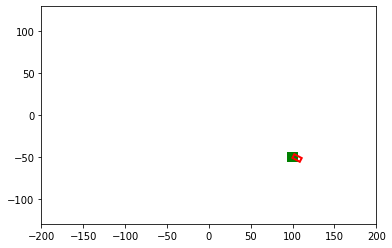

In [ ]:
render_w = 200
render_h = 200
curIdx = 2
states = states_list[curIdx]

frames_to_draw = len(states)
print("Rendering",frames_to_draw,"frames")

gx = g_arr[curIdx][0]
gy = g_arr[curIdx][1]

states,actions = run_model(mean_policy, (-100,100,0),(100,-50))
gx =100
gy=-50

#Matplot lib animation magic...
#Check here for a lot more: https://jakevdp.github.io/blog/2012/08/18/matplotlib-animation-tutorial/

fig = plt.figure()
ax = plt.gca()

def init():
  ax.cla()
  ax.axis('equal')
  ax.set(xlim=(-render_w, render_w),ylim=(-render_h, render_h))
  return fig,

def animate(i):
  ax.cla()
  ax.axis('equal')
  #Draw area
  ax.set(xlim=(-render_w, render_w),ylim=(-render_h, render_h))
  #Draw goal
  goal_w = car_l
  rect = Rectangle((gx-goal_w/2,gy-goal_w/2),goal_w,goal_w,linewidth=2,edgecolor='g',facecolor='g')
  #Draw agent
  ax.add_patch(rect)
  cx = states[i][0]
  cy = states[i][1]
  theta = states[i][2]
  ang = np.rad2deg(theta)
  rect = Rectangle((cx+car_w/2*sin(theta),cy-car_w/2*cos(theta)),car_l,car_w,angle=np.rad2deg(theta),linewidth=2,edgecolor='r',facecolor='none')
  ax.add_patch(rect)
  return fig,

anim = animation.FuncAnimation(fig, animate, init_func=init,frames=frames_to_draw,interval=dt*1000,repeat_delay=1500,blit=True)
rc('animation', html='jshtml')
anim

In [ ]:
states_list = []
actions_list =[]

gx =100
gy=-50
s1_arr = np.array([[-100,40,0],[-90,60,0],[-110,50,0],[-100,100,0]])
#g1_arr = np.array([[100,-60,0],[100,-40,0],[120,-50,0],[90,-50,0]])
g1_arr = np.array([[100,-50],[100,-50],[100,-50],[100,-50]])
s1_arr=s_arr
g1_arr=g_arr

for s, g in zip(s1_arr,g1_arr):
  temp_states, temp_actions = run_model(mean_policy, (s[0],s[1],s[2]),(g[0],g[1]))
  states_list.append(temp_states)


Rendering 81 frames


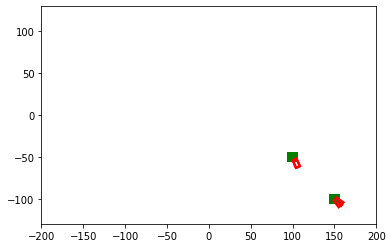

In [ ]:
render_w = 200
render_h = 200

frames_to_draw = len(states_list[0])
print("Rendering",frames_to_draw,"frames")

#Matplot lib animation magic...
#Check here for a lot more: https://jakevdp.github.io/blog/2012/08/18/matplotlib-animation-tutorial/

fig = plt.figure()
ax = plt.gca()

def init():
  ax.cla()
  ax.axis('equal')
  ax.set(xlim=(-render_w, render_w),ylim=(-render_h, render_h))
  return fig,

def animate(i):
  ax.cla()
  ax.axis('equal')
  #Draw area
  ax.set(xlim=(-render_w, render_w),ylim=(-render_h, render_h))
  #Draw goal
  for g in g1_arr:
    goal_w = car_l
    rect = Rectangle((g[0]-goal_w/2,g[1]-goal_w/2),goal_w,goal_w,linewidth=2,edgecolor='g',facecolor='g')
    ax.add_patch(rect)
  #Draw agent
  for states in states_list:  
    cx = states[i][0]
    cy = states[i][1]
    theta = states[i][2]
    ang = np.rad2deg(theta)
    rect = Rectangle((cx+car_w/2*sin(theta),cy-car_w/2*cos(theta)),car_l,car_w,angle=np.rad2deg(theta),linewidth=2,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
  return fig,

anim = animation.FuncAnimation(fig, animate, init_func=init,frames=frames_to_draw,interval=dt*1000,repeat_delay=1500,blit=True)
rc('animation', html='jshtml')
anim

In [ ]:
filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      video.append_data(eval_py_env.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(eval_py_env.render())

In [ ]:
import imageio
import PIL.Image
import pyvirtualdisplay